In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [2]:
import ranking_funcs

In [3]:
df=ranking_funcs.read_data('German.csv')

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


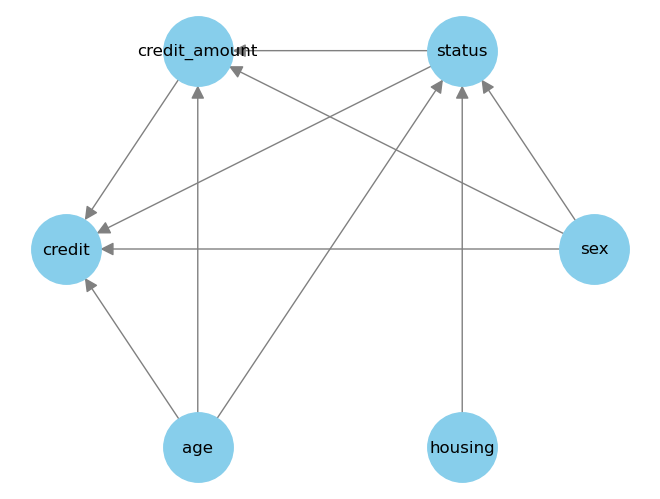

In [4]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit'),('status', 'credit_amount')])


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

plt.savefig(f'ranking_plots/causal_graph_German.png')
plt.show()

In [5]:
new_G_combined=ranking_funcs.get_new_G_combined(G,df)
new_G_combined_rf=ranking_funcs.get_new_G_combined_rf(G,df)

In [6]:
X=df[['sex', 'status', 'age', 'housing']]
y=df['credit_amount']

updated_df=ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'status':1}, 'credit_amount',{'age':1},'fix')
updated_df_X=updated_df[['sex', 'status', 'age', 'housing']]
updated_df_y=updated_df['credit_amount']

In [7]:
rf_estimator=RandomForestRegressor(random_state=1234).fit(X, y)
rf_result=rf_estimator.predict(updated_df_X)
updated_df['rf_prediction']=rf_result
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)
rf_order

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings,rf_prediction
520,2,1.0,0.751984,1,5727.543094,1,4.0,5.0,1.0,0,...,3.0,0.0,3.0,1.0,0.0,0,1.0,2.0,0,6010.804930
774,1,1.0,0.875992,0,1590.271547,1,0.0,2.0,1.0,0,...,3.0,0.0,2.0,1.0,0.0,0,1.0,0.0,1,6010.804930
353,1,1.0,0.124008,1,6088.728453,1,2.0,4.0,1.0,0,...,1.0,0.0,4.0,1.0,1.0,0,1.0,2.0,0,6010.804930
648,2,1.0,-0.124008,0,1057.271547,0,3.0,2.0,1.0,0,...,3.0,0.0,4.0,2.0,0.0,0,1.0,2.0,0,6010.804930
903,2,1.0,0.751984,1,1606.543094,0,2.0,4.0,1.0,0,...,0.0,0.0,4.0,1.0,1.0,0,1.0,2.0,2,6010.804930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1,0.0,1.000000,1,585.000000,1,2.0,4.0,1.0,0,...,0.0,0.0,4.0,1.0,0.0,1,1.0,2.0,0,1950.802520
58,2,0.0,1.000000,1,1961.000000,0,4.0,2.0,0.0,1,...,2.0,0.0,3.0,1.0,0.0,0,2.0,3.0,0,1853.343030
834,2,0.0,0.000000,1,2327.000000,0,0.0,4.0,0.0,1,...,0.0,0.0,2.0,1.0,0.0,0,2.0,0.0,0,1853.343030
604,0,0.0,1.000000,1,1275.000000,0,0.0,3.0,0.0,1,...,1.0,0.0,4.0,1.0,0.0,0,2.0,2.0,0,1853.343030


In [8]:
X_const = sm.add_constant(X)
updated_X_const = sm.add_constant(updated_df_X)
ols_model = sm.OLS(y, X_const).fit()
ols_result = ols_model.predict(updated_X_const)
updated_df['ols_prediction']=ols_result
ols_order=updated_df.sort_values(by='ols_prediction',ascending=False)

In [9]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined_rf, df, len(df), {'status':1}, 'credit_amount',
                         {'age':1},"fix")

backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined_rf, df, len(df), {'status':1}, 'credit_amount',
                         {'age':1},"fix")

In [10]:
rf_results=[]
rf_results_in_topk=[]

ols_results = []
ols_results_in_topk = []

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))
    
    ols_results.append(ranking_funcs.accuracy_topk_rank(ols_order.head(i).index,updated_df.head(i).index))
    ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_order.head(i).index,updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))

In [11]:
df_top_k_accuracy=pd.DataFrame({'Random forest':rf_results,'linear regression':ols_results,
                               'Hyper:Backdoor Criterion':back_door_opt1_with_combined_G,
                                'Hyper:BSCPM':back_door_opt2_with_combined_G,
                               'Top_k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'Random forest':rf_results_in_topk,'linear regression':ols_results_in_topk,
                               'Hyper:Backdoor Criterion':back_door_opt1_with_combined_G_in_topk,
                                'Hyper:BSCPM':back_door_opt2_with_combined_G_in_topk,
                                'Top_k_range':range(1,len(updated_df)+1)})

In [12]:
df_in_top_k_accuracy.head(10)

,Random forest,linear regression,Hyper:Backdoor Criterion,Hyper:BSCPM,Top_k_range
0,0.0,0.0,1.000000,0.0,1
1,0.0,0.0,0.500000,0.0,2
2,0.0,0.0,0.333333,0.0,3
3,0.0,0.0,0.250000,0.0,4
4,0.0,0.0,0.200000,0.0,5
5,0.0,0.0,0.166667,0.0,6
6,0.0,0.0,0.142857,0.0,7
7,0.0,0.0,0.125000,0.0,8
8,0.0,0.0,0.111111,0.0,9
9,0.0,0.0,0.100000,0.0,10


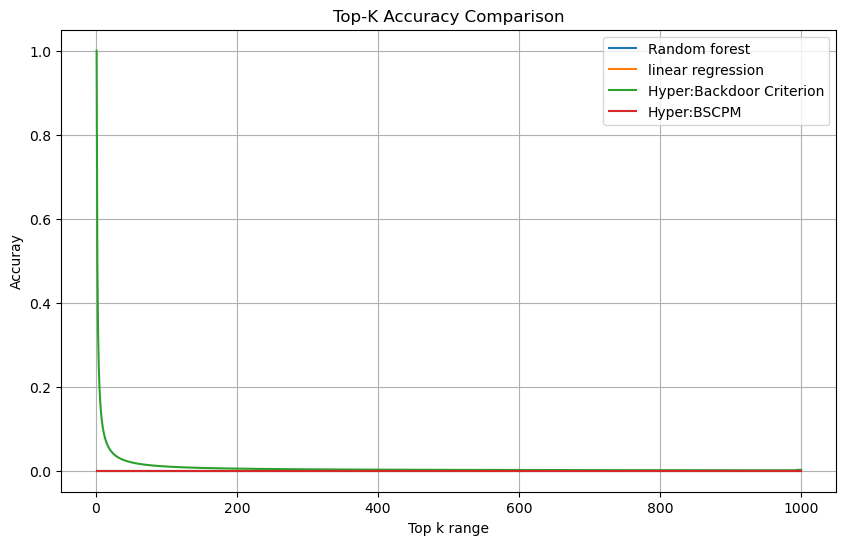

In [13]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["Top_k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("Top k range")
plt.ylabel("Accuray")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison_german.png')

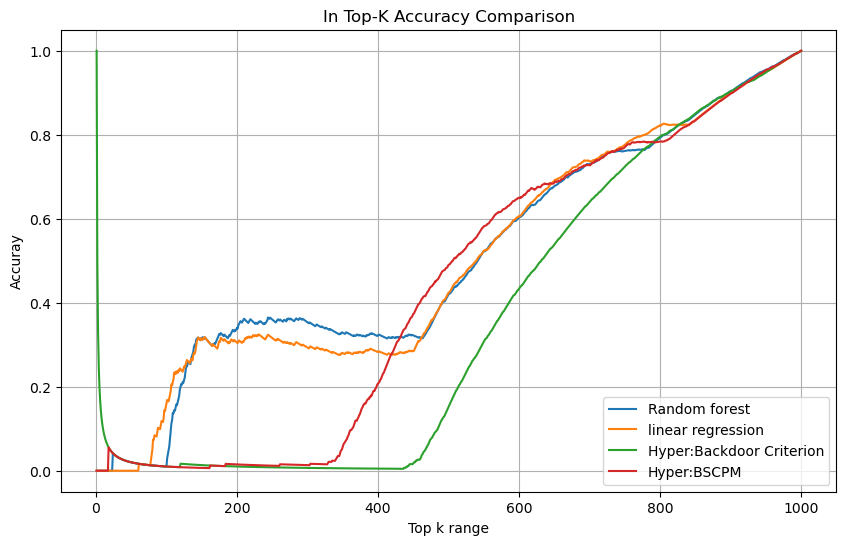

In [14]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["Top_k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("Top k range")
plt.ylabel("Accuray")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison_german.png')
plt.show()

In [15]:
updated_df['true_row_index']=updated_df.index
rf_order['true_row_index']=rf_order.index
ols_order['true_row_index']=ols_order.index
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')
merged_df['true_row_index']=merged_df.index

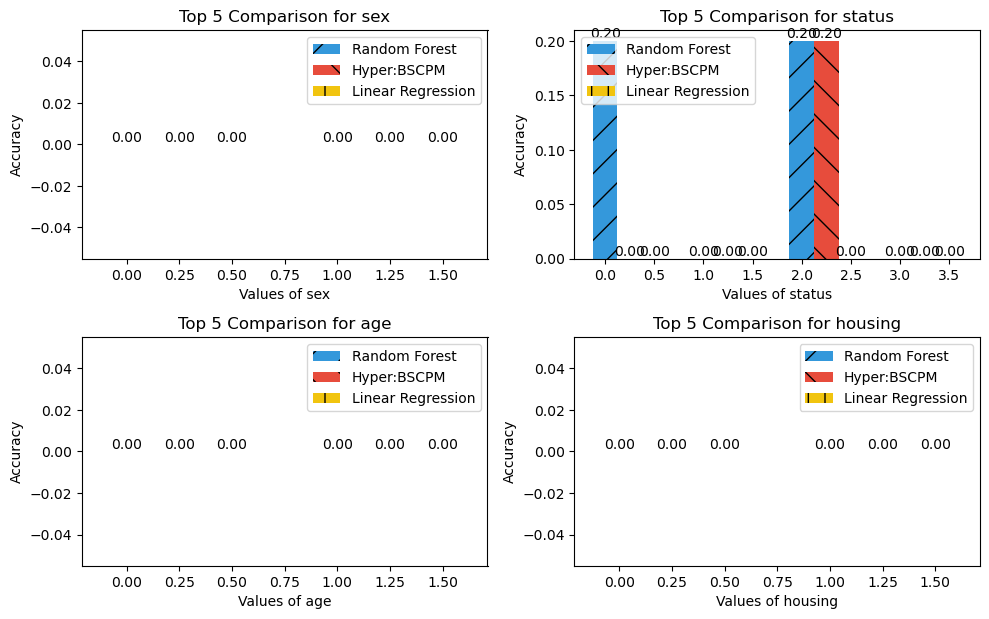

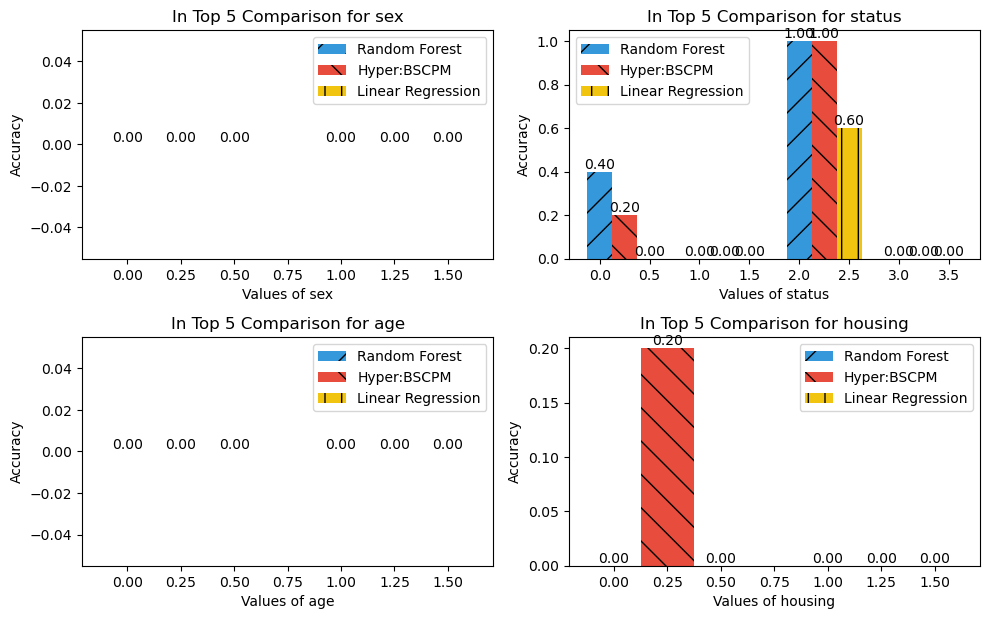

In [16]:
Xs =['sex', 'status', 'age', 'housing']


plt.figure(figsize=(10, 3 * len(Xs)))

colors = {
    'random_forest': '#3498db', 
    'backdoor_method2_with_combined_effect': '#e74c3c', 
    'OLS': '#f1c40f' 
}

hatches = ['/', '\\', '|', '-']


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest', hatch=hatches[0])
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Hyper:BSCPM', hatch=hatches[1])
    bars3 = plt.bar(r3, df_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='Linear Regression', hatch=hatches[2])
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_5_comparison_all_features_German.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest', hatch=hatches[0])
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Hyper:BSCPM', hatch=hatches[1])
    bars3 = plt.bar(r3, df_in_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='Linear Regression', hatch=hatches[2])
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')
            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 5 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_5_comparison_all_features_German.png')
plt.show()

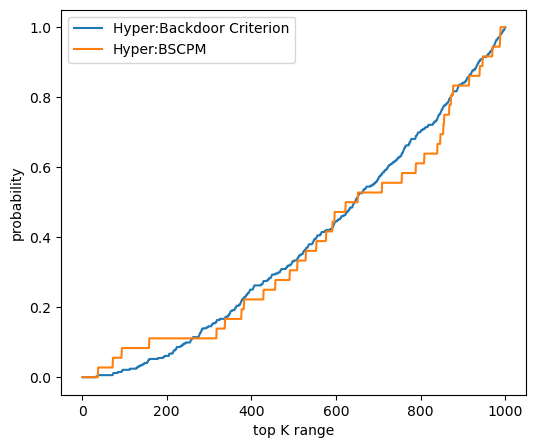

In [17]:
#The tupple 1
k_range_backdoor_val,k_range_backdoor2_val=ranking_funcs.k_range_backdoor(new_G_combined,new_G_combined_rf, df, 1, {'status':2}, 'credit_amount', {'property':0}, 'fix', [1],len(df))
x_values = range(1, len(df)+1)    
plt.figure(figsize=(6, 5))
plt.plot(x_values, k_range_backdoor_val, label='Hyper:Backdoor Criterion')
plt.plot(x_values, k_range_backdoor2_val, label='Hyper:BSCPM')
plt.xlabel('top K range')
plt.ylabel('probability')
plt.legend()

plt.savefig(f'ranking_plots/topk_range_backdoor_german.png')
plt.show()

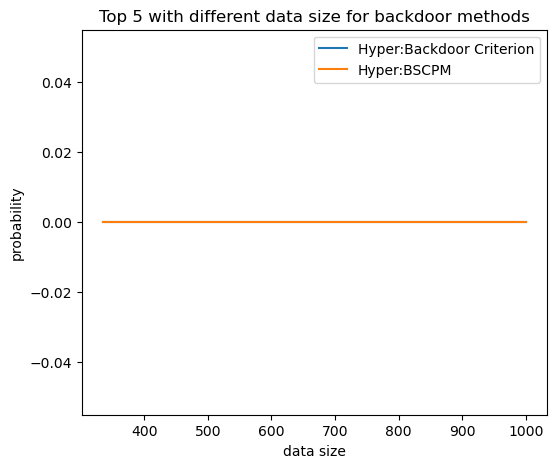

In [18]:
lenth,data_size_backdoor_val,data_size_backdoor2_val=ranking_funcs.data_size_backdoor(new_G_combined,new_G_combined_rf, df, 3, {'status':2}, 'credit_amount', {'property':0}, 'fix', [1],6,123)
plt.figure(figsize=(6, 5))
plt.plot(lenth, data_size_backdoor_val, label='Hyper:Backdoor Criterion')
plt.xlabel('data size')
plt.ylabel('probability')

plt.plot(lenth, data_size_backdoor2_val, label='Hyper:BSCPM')
plt.xlabel('data size')
plt.ylabel('probability')
plt.title(f'Top 5 with different data size for backdoor methods')
plt.legend()

plt.savefig(f'ranking_plots/topk_backdoor_range_german.png')
plt.show()

In [19]:
var=['status']
df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df, 5, 'credit_amount',var,0, {'property':1},100, "add",2)
df_gr

,rank,prob,total_iters
0,"[915, 95, 818, 887, 637]",0.08,8.0
1,"[95, 915, 818, 887, 637]",0.01,1.0
2,"[95, 818, 887, 637, 915]",0.03,3.0
3,"[95, 818, 887, 637, 917]",0.88,88.0


In [20]:
row_indexes=[95, 818, 887, 637, 917]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'credit_amount',var,1, {'property':0} ,100, "add",2)

gbval1=np.sum(greedy_backdoor)/50
gbval2=np.sum(greedy_backdoor2)/50

In [21]:
row_indexes=[95, 818, 887, 637, 915]
greedy_backdoor,greedy_backdoor2=ranking_funcs.Comp_Greedy_Algo_backdoor_edited(row_indexes,new_G_combined, df, 5, 'credit_amount',var,1, {'property':0} ,100, "add",2)

gbval11=np.sum(greedy_backdoor)/50
gbval22=np.sum(greedy_backdoor2)/50

In [22]:
baseline_val=ranking_funcs.base_line(df,5)**5

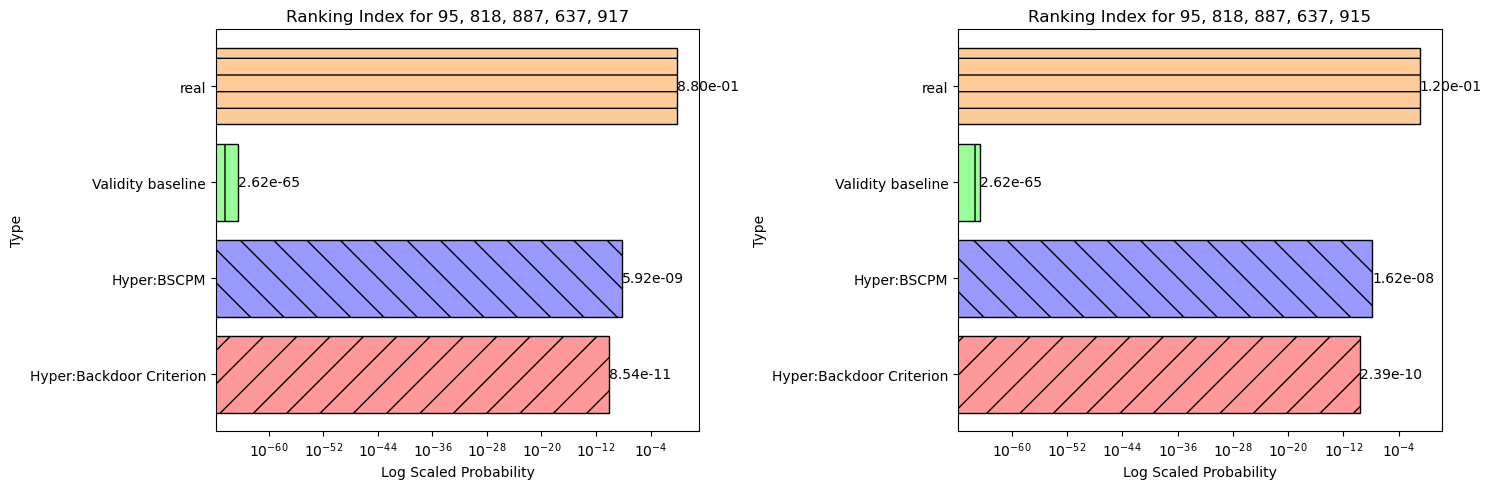

In [23]:

data1 = {'Hyper:Backdoor Criterion': gbval1,'Hyper:BSCPM': gbval2, 'Validity baseline':baseline_val,'real': 0.88}
data2 = {'Hyper:Backdoor Criterion': gbval11,'Hyper:BSCPM':gbval22,  'Validity baseline':baseline_val,'real': 0.12}

data=[data1, data2]

types = ['Hyper:Backdoor Criterion','Hyper:BSCPM','Validity baseline','real']

colors = {'Hyper:Backdoor Criterion': '#FF9999', 'Hyper:BSCPM': '#9999FF', 'Validity baseline': '#99FF99', 'real': '#FFCC99'}

titles = [
    "Ranking Index for 95, 818, 887, 637, 917",
    "Ranking Index for 95, 818, 887, 637, 915"
]


hatches = ['/', '\\', '|', '-']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, d in enumerate(data):
    values = [d[t] for t in types]  
    keys = types  
    colors_list = [colors[t] for t in keys] 

    bars = axes[i].barh(keys, values, color=colors_list, edgecolor='black')
    
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Type')
    axes[i].set_yticks(range(len(keys)))
    axes[i].set_yticklabels(keys)
    axes[i].set_xlabel('Log Scaled Probability')
    axes[i].set_xscale('log')
    

    for bar, value in zip(bars, values):
        axes[i].text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 '{:.2e}'.format(value), va='center')

plt.tight_layout()
plt.savefig(f'ranking_plots/greedy_cgs_german.png')
plt.show()

In [24]:
import time

In [25]:
def Comp_Greedy_Algo_backdoor2(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    prob_result2=[]
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1]
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=ranking_funcs.get_ranking_query(G, df, len(df), {var:x_up}, target_column, condition, opt)
                theta=updated_df[target_column].iloc[k-1] 
                prob_backdoor2=ranking_funcs.get_prob_backdoor_opt2(G, df, k, {var:x_up}, target_column, condition, opt, row_indexes, theta)
                prob_result2.append(prob_backdoor2)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result2

In [26]:
df_subsets=df.head(50)
iter_times=[10,50,100,150,200,250,300,350]
var=['status']
time_greedy_algo=[]

for i in iter_times:
    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df, 5, 'credit_amount',var,0, {'property':1},i, "add",2)
    end_time = time.time()
    time_greedy_algo.append(end_time - start_time)
    
time_greedy_backdoor=[]
row_indexes=[0, 1, 2, 7, 8]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G_combined, df, 5, 'credit_amount',var,0, {'property':1},i, "add",2)
    end_time = time.time()
    time_greedy_backdoor.append(end_time - start_time)
    
time_greedy_backdoor2=[]

for i in iter_times:
    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G_combined, df, 5, 'credit_amount',var,0, {'property':1},i, "add",2)
    end_time = time.time()
    time_greedy_backdoor2.append(end_time - start_time)
    


In [27]:
time_greedy = pd.DataFrame({'Iteration times':iter_times,'Hyper:Naive algorithm':time_greedy_algo,'Hyper:Backdoor Criterion':time_greedy_backdoor,'Hyper:BSCPM':time_greedy_backdoor2})

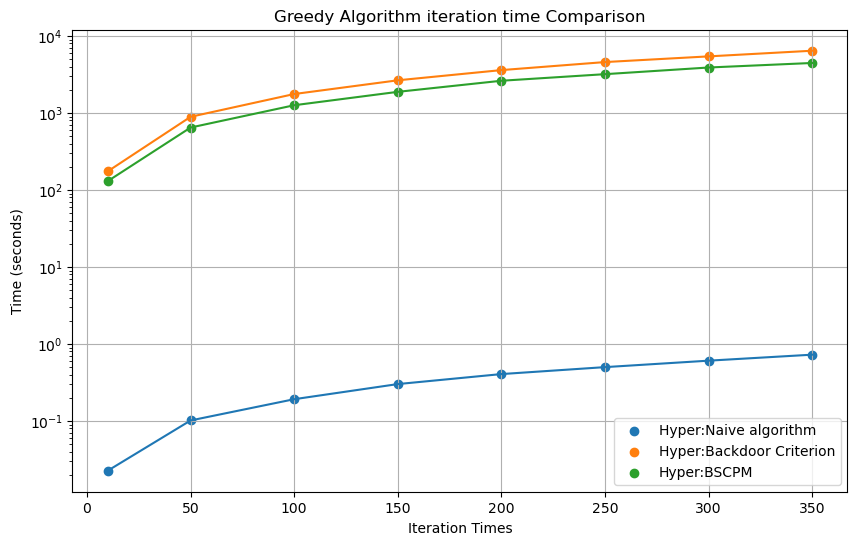

In [28]:
plt.figure(figsize=(10, 6))
for column in time_greedy.columns[1:]:
    plt.scatter(time_greedy["Iteration times"], time_greedy[column], label=column)
    plt.plot(time_greedy["Iteration times"], time_greedy[column])

ax = plt.gca()  
ax.set_yscale('log')
plt.xlabel("Iteration Times")
plt.ylabel("Time (seconds)")
plt.title("Greedy Algorithm iteration time Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/time_comparision_greedy_german.png')
plt.show()

In [29]:
i_range=[10,50,100,150,200,250]
time_greedy_algo_data=[]
time_greedy_backdoor_data=[]
time_greedy_backdoor2_data=[]
df_rows=df.loc[row_indexes]
df_dropped = df.copy().drop(row_indexes)

for i in i_range:
    df_subsets=pd.concat([df_dropped.sample(i-5),df_rows])

    start_time = time.time()
    df_gr=ranking_funcs.Greedy_Algo(new_G_combined, df_subsets, 5, 'credit_amount',var,0, {'property':1},1, "add",2)
    end_time = time.time()
    time_greedy_algo_data.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=ranking_funcs.Comp_Greedy_Algo_backdoor(row_indexes,new_G_combined, df_subsets, 5, 'credit_amount',var,1, {'property':1} ,1, "add",2)
    end_time = time.time()
    time_greedy_backdoor_data.append(end_time - start_time)


    start_time = time.time()
    greedy_backdoor=Comp_Greedy_Algo_backdoor2(row_indexes,new_G_combined, df_subsets, 5, 'credit_amount',var,1, {'property':1} ,1, "add",2)
    end_time = time.time()
    time_greedy_backdoor2_data.append(end_time - start_time)

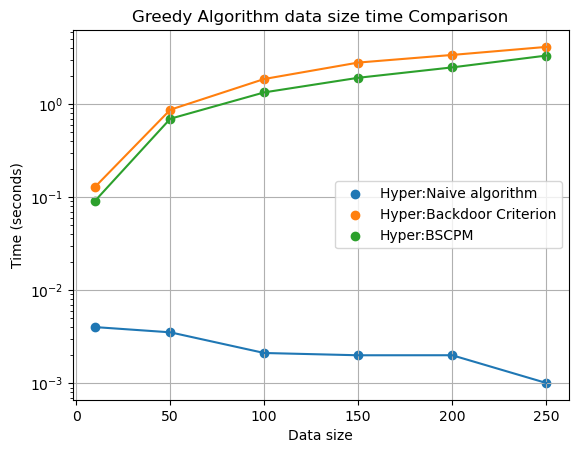

In [30]:
time_greedy_data = pd.DataFrame({'Data_size':i_range,'Hyper:Naive algorithm':time_greedy_algo_data,'Hyper:Backdoor Criterion':time_greedy_backdoor_data,'Hyper:BSCPM':time_greedy_backdoor2_data})

for column in time_greedy.columns[1:]:
    plt.scatter(time_greedy_data["Data_size"], time_greedy_data[column], label=column)
    plt.plot(time_greedy_data["Data_size"], time_greedy_data[column])

ax = plt.gca()  
ax.set_yscale('log')
plt.xlabel("Data size")
plt.ylabel("Time (seconds)")
plt.title("Greedy Algorithm data size time Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/time_comparision_data_german.png')
plt.show()